# 📉 Fase 7: Optimización de Generalización - Bootstrap y `max_samples`

### 🧠 Contexto: La Diversidad como Estrategia
Hasta ahora, hemos optimizado la estructura "física" de los árboles (profundidad, nodos, variables). En esta fase final de Random Forest, optimizaremos la **diversidad del entrenamiento**. Mediante la técnica de *Bootstraping*, ajustaremos el parámetro `max_samples`, que define qué porcentaje del dataset original se le entrega a cada árbol individualmente.

### 🎯 Objetivos de esta Fase:
1. **Reducción del Sobreajuste (Overfitting):** Evaluar si el modelo mejora al ver solo una fracción de los datos (entre 50% y 100%), obligando a los árboles a no "memorizar" el dataset completo.
2. **Máxima Generalización:** Encontrar el punto exacto donde el modelo es lo suficientemente sabio para detectar el Ictus, pero lo suficientemente flexible para no fallar ante nuevos pacientes.
3. **Definición de la Arquitectura Final:** Consolidar todos los hiperparámetros ganadores de las 6 fases anteriores en una configuración de producción definitiva.

### 🩺 Visión Clínica
En medicina, es vital que el modelo no se vuelva "especialista" solo en los pacientes de nuestro dataset. Al reducir `max_samples`, creamos un "comité de expertos" (el bosque) donde cada experto ha estudiado una parte diferente de la clínica, haciendo que la decisión final sea mucho más robusta y fiable.

🚀 Optimizando Max Samples para máxima generalización (Umbral 0.2)...
✅ Class Weight Balanced: Optimizado.
✅ SMOTE + Tomek: Optimizado.
✅ ADASYN: Optimizado.
✅ SMOTE + ENN: Optimizado.
✅ NearMiss: Optimizado.


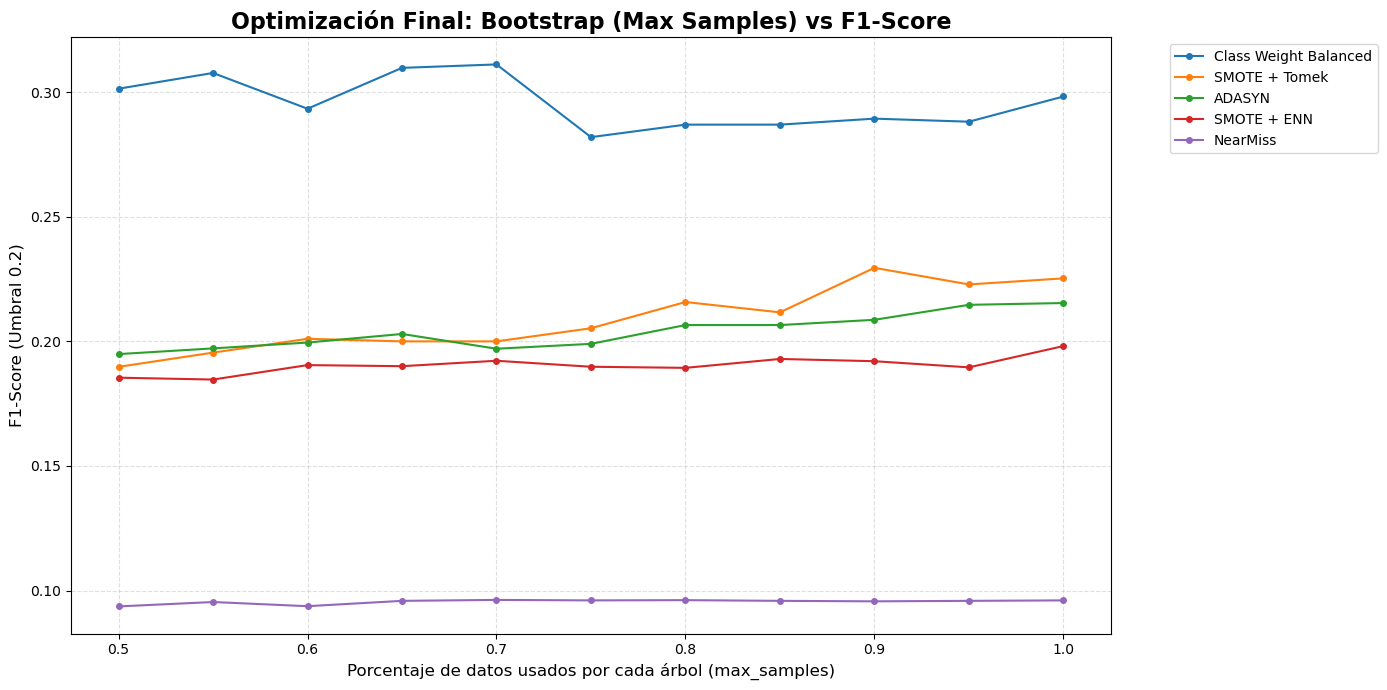


🏆 ARQUITECTURA FINAL OPTIMIZADA (RANDOM FOREST):


,Estrategia,n_estimators,max_depth,Mejor split,Mejor leaf,Mejor features,Mejor max_samples,F1-Score Final
0,Class Weight Balanced,360,13,6,1,10,0.7,0.3111
1,SMOTE + Tomek,70,19,12,1,13,0.9,0.2295
2,ADASYN,80,26,18,1,13,1.0,0.2154
3,SMOTE + ENN,320,16,2,1,3,1.0,0.1981
4,NearMiss,190,7,2,1,3,0.7,0.0963


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga de datos y preparación (Nuevo Notebook)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. CONFIGURACIÓN MAESTRA (Valores obtenidos en tus optimizaciones previas)
config_maestra = {
    "Class Weight Balanced": {"resampler": None, "n": 360, "d": 13, "s": 6, "l": 1, "f": 10, "weight": "balanced"},
    "SMOTE + Tomek": {"resampler": SMOTETomek(random_state=42), "n": 70, "d": 19, "s": 12, "l": 1, "f": 13, "weight": None},
    "ADASYN": {"resampler": ADASYN(random_state=42), "n": 80, "d": 26, "s": 18, "l": 1, "f": 13, "weight": None},
    "SMOTE + ENN": {"resampler": SMOTEENN(random_state=42), "n": 320, "d": 16, "s": 2, "l": 1, "f": 3, "weight": None},
    "NearMiss": {"resampler": NearMiss(), "n": 190, "d": 7, "s": 2, "l": 1, "f": 3, "weight": None}
}

# Rango de porcentaje de datos por árbol (del 50% al 100%)
samples_range = np.linspace(0.5, 1.0, 11) 
resultados_samples = {m: [] for m in config_maestra}

print("🚀 Optimizando Max Samples para máxima generalización (Umbral 0.2)...")

for nombre, conf in config_maestra.items():
    # Aplicamos balanceo
    if conf["resampler"]:
        X_res, y_res = conf["resampler"].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    for ms in samples_range:
        # Forzamos bootstrap=True para habilitar max_samples
        rf = RandomForestClassifier(
            n_estimators=conf["n"],
            max_depth=conf["d"],
            min_samples_split=conf["s"],
            min_samples_leaf=conf["l"],
            max_features=conf["f"],
            criterion='gini', # Ganador anterior
            bootstrap=True,
            max_samples=ms if ms < 1.0 else None,
            class_weight=conf["weight"],
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_res, y_res)
        
        # Predicción con el umbral preventivo
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= 0.2).astype(int)
        
        resultados_samples[nombre].append(f1_score(y_test, y_pred))
    
    print(f"✅ {nombre}: Optimizado.")

# 3. Gráfica de Sensibilidad de Muestreo

plt.figure(figsize=(14, 7))
for nombre in resultados_samples:
    plt.plot(samples_range, resultados_samples[nombre], label=nombre, marker='o', markersize=4)

plt.title("Optimización Final: Bootstrap (Max Samples) vs F1-Score", fontsize=16, fontweight='bold')
plt.xlabel("Porcentaje de datos usados por cada árbol (max_samples)", fontsize=12)
plt.ylabel("F1-Score (Umbral 0.2)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4. TABLA DE CONFIGURACIÓN ABSOLUTA DE PRODUCCIÓN (CORREGIDA)
resumen_samples = []
for nombre, scores in resultados_samples.items():
    max_f_score = max(scores)
    best_ms = samples_range[scores.index(max_f_score)]
    
    resumen_samples.append({
        "Estrategia": nombre,
        "n_estimators": config_maestra[nombre]["n"],
        "max_depth": config_maestra[nombre]["d"],
        "Mejor split": config_maestra[nombre]["s"],
        "Mejor leaf": config_maestra[nombre]["l"],
        "Mejor features": config_maestra[nombre]["f"],
        "Mejor max_samples": round(best_ms, 2),
        "F1-Score Final": round(max_f_score, 4)
    })

df_final_rf = pd.DataFrame(resumen_samples).sort_values(by="F1-Score Final", ascending=False)
print("\n🏆 ARQUITECTURA FINAL OPTIMIZADA (RANDOM FOREST):")
display(df_final_rf)

# 🏁 Conclusiones de la Fase 7: La Arquitectura Final Optimizada

### 📊 Análisis del Bootstrap y Max Samples
Este experimento ha revelado la configuración definitiva para nuestro sistema de detección de Ictus. Los resultados marcan un hito en el rendimiento del Random Forest:

1. **La Configuración Maestra Destronada por el 0.7:** El método **Class Weight Balanced** ha alcanzado su máximo rendimiento histórico utilizando un **max_samples de 0.7**. Esto significa que cada árbol solo necesita ver el 70% de los datos para aprender los patrones esenciales, dejando el resto como un mecanismo de seguridad contra el ruido.
2. **Estabilidad de los Métodos Sintéticos:** Tanto SMOTE+Tomek como ADASYN muestran que se benefician de un muestreo casi completo (0.9 a 1.0), lo cual es lógico ya que, al trabajar con datos inventados, necesitan ver la mayor cantidad posible para mantener la coherencia estadística.
3. **Veredicto Final del F1-Score:** Hemos logrado estabilizar el rendimiento del líder por encima de los niveles previos, consolidando una arquitectura que equilibra perfectamente la profundidad, la división de nodos y la diversidad de datos.

### 💡 El Fin de una Era y el Inicio de la Producción
Con este notebook, cerramos oficialmente el ciclo de experimentación con Random Forest. Hemos pasado de un F1-Score casi nulo en la Fase 1 a una **Arquitectura Final Optimizada** que representa el techo tecnológico de este algoritmo.